<a href="https://colab.research.google.com/github/leonardo-caldeira/Path-Planning/blob/main/Path_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho 1 - Inteligência Artificial

* Bruna Castro
  * 11819702
* Leonardo Caldeira Gonçalves
  * 11803013
* Pedro Azevedo
  * 11802565
* Vítor Beneti Martins
  * 11877635

## 1. Problema
O problema escolhido foi a **movimentação** de um **robô autônomo** que atua no ambiente de uma fábrica. Seu objetivo é transitar entre dois pontos utilizando o menor caminho possível, tendo como restrições: evitar colisão com pessoas e obstáculos dentro de um raio pré-determinado.

### 1. 1. Motivacao

Atualmente, os [robôs móveis autônomos](https://www.controleng.com/articles/autonomous-mobile-robots-role-growing-in-industrial-operations/) em ambientes industriais. Dentre as vantagens dessas maquinas, destaca-se a [flexibilidade](https://digital.futurecom.com.br/transformacao-digital/por-que-sua-fabrica-precisa-de-robos-moveis), já que podem transitar em todo o ambiente da fábrica, a fim de exercer tarefas variadas.

Visto a crescente inserção desses modelos no mercado, torna-se necessário o cuidado especial em relação a segurança (pois sempre há a presença de operários no local) e a otimização de recursos na sua implementacao em uma fábrica. Para atingir ambos os objetivos, é essencial o investimento no seu mecanismo de mapeamento do ambiente e navegação, a fim de otimizar a sua busca do melhor caminho entre dois pontos.

### 1. 2. Modelagem
O modelo escolhido inclui quatro parâmetros principais: o custo do passo do robô, o raio de segurança (para que não haja colisão com nenhum obstáculo) e os pontos inicial e final do percurso.
Para o primeiro parâmetro, o custo para o passo em direções ortogonais (Norte, Sul, Leste e Oeste) é equivalente, já para os passos em direções diagonais, há um fator de $\sqrt{2}$ nesse custo.

Dessa forma, a partir do "passo",todo o ambiente de movimentação do robô é mapeado em pontos discretos. Após isso, para cada um dos pontos, é avaliada a sua distância dos obstáculos contidos no mapa. Se essa distância para algum dos obstáculos for menor do que o parâmetro de raio de segurança do robô, o ponto é dado como **inacessível** para o campo de atuação do robô e desconsiderado no algoritmo de busca.

Com isso, tendo o *grid* de possibilidade de posições seguras para robô e suas possibilidades de movimentação (frente/trás, esquerda/direita e direções diagonais), foram utilizados algoritmos de busca a fim de encontrar o menor caminho possível entre o ponto inicial e o final respeitando com essas restrições.

## 2. Implementação do problema

Para tornar possível o emprego dos algoritmos de pesquisa, o espaço físico de uma fábrica foi mapeado em uma grade discretizada com coordenadas cartesianas. A grade contém dados sobre as localizações dos obstáculos na rota e mantém um registro das posições onde o movimento do robô é autorizado.


Cada nó presente nessa grade contém informações sobre sua coordenada, o custo da rota atual e qual é o nó que o precede.



In [ ]:
#Importando bibliotecas utilizadas
import matplotlib.pyplot as plt
import math
import numpy as np
import time

In [ ]:
#Definindo classe dos nós
class No:
    def __init__(self, x, y, custo, no_pai):
        self.x = x
        self.y = y
        self.custo = custo
        self.no_pai = no_pai

In [ ]:
#Definindo classe do grid
class Grid:
    def __init__(self, ox, oy, passo, raio_robo):
        self.ox = ox
        self.oy = oy
        self.passo = passo
        self.raio_robo = raio_robo

        # discretiza o grid de acordo com o tamanho do passo inserido
        self.obstaculos_x = [iox / passo for iox in ox]
        self.obstaculos_y = [ioy / passo for ioy in oy]

        self.min_x = round(min(obstaculos_x))
        self.min_y = round(min(obstaculos_y))
        self.max_x = round(max(obstaculos_x))
        self.max_y = round(max(obstaculos_y))
        self.largura = round(self.max_x - self.min_x)
        self.altura = round(self.max_y - self.min_y)
        # cria um mapa para o grid que inicialmente guarda todas as posicoes do grid como False
        self.map = [[False for _ in range(self.altura)] for _ in range(self.largura)]

        # mapeia todos os pontos desse mapa para marcar todos os pontos inacessíveis como True
        for ix in range(self.largura):
            x = ix + self.min_x
            for iy in range(self.altura):
                y = iy + self.min_y
                for iox, ioy in zip(self.obstaculos_x, self.obstaculos_y):
                    d = math.sqrt((iox - x) ** 2 + (ioy - y) ** 2)
                    # se a distancia entre o ponto e o obstaculo for menor do que o raio do robo, entao o ponto eh inacessivel
                    if d <= raio_robo / passo:
                        self.map[ix][iy] = True
                        break

Para fim de comparação, será implementado e testado a **Busca em Largura** e dois algoritmos de busca de menor caminho em grafos : **Dijkstra** e **A***:

## 3. Busca não informada (BFS)

Essa busca não possui informações sobre o problema e por isso sempre expande primeiro os nós mais próximos do nó inicial.

In [ ]:
# Definindo funcao que calcula o menor caminho entre o ponto inicial e final considerando um ma
def BFS(no_inicial, no_final, grid):
    '''Recebe um No inicial, um No final e um grid mapeado (classe Grid).
    Retorna o caminho entre os nós por meio do algoritmo de busca em largura'''

    # Inicializando a fila de nós a serem visitados com o nó inicial
    fila = [no_inicial]
    # Inicializando o dicionário de nós visitados
    nos_visitados = dict()
    nos_visitados[(no_inicial.x,no_inicial.y)] = no_inicial

    while fila:
        # Retira o primeiro nó da fila
        no_atual = fila.pop(0)

        # Verifica se o nó atual é o nó final
        if no_atual.x == no_final.x and no_atual.y == no_final.y:
            no_final.no_pai = no_atual.no_pai
            no_final.custo = no_atual.custo
            break

        # Gera todos os movimentos possíveis a partir do nó atual
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:

                #Atribui o custo de acordo com o tipo de movimento(diagonal ou vertical/horizontal)
                if abs(dx)==abs(dy):
                    custo=math.sqrt(2)
                else:
                    custo=1

                novo_no = No(no_atual.x + dx, no_atual.y + dy, no_atual.custo + custo, (no_atual.x,no_atual.y))

                #Verifica se o nó já foi visitado
                if (novo_no.x,novo_no.y) in nos_visitados:
                    continue

                # Verifica se o próximo nó é válido
                if not (0 <= novo_no.x < grid.largura and 0 <= novo_no.y < grid.altura and not grid.map[novo_no.x][novo_no.y]):
                    continue
                else:#Adciona o nó à fila
                    nos_visitados[(novo_no.x,novo_no.y)] = novo_no
                    fila.append(novo_no)

    #Inicializa o trajeto do caminho encontrado
    caminho_x, caminho_y = [no_final.x * passo], [no_final.y * passo]
    no_pai = no_final.no_pai

    #Faz o  percurso inverso do nó final até o nó inicial e armazena o caminho
    while no_pai != -1:
        n = nos_visitados[no_pai]
        caminho_x.append(n.x * passo)
        caminho_y.append(n.y * passo)
        no_pai = n.no_pai

    return caminho_x, caminho_y, nos_visitados

## 4. Busca informada (Dijkstra)

Essa busca não possui informações sobre o custo futuro. Dessa forma, apenas o valor até um nó vizinho é considerado. Além disso, o algoritmo de Dijkstra é guloso, pois escolhe a alternativa com o menor custo a cada iteração. Com isso, o algoritmo sempre encontra uma solução, a não ser que as arestas tenham pesos negativos.

In [ ]:
# Definindo funcao que calcula o menor caminho entre o ponto inicial e final considerando um ma
def Dijkstra(no_inicial, no_final, grid):
    '''Recebe um No inicial, um No final e um grid mapeado (classe Grid).
    Retorna o menor caminho ótimo entre os nós por meio do algoritmo de Dijkstra'''

    nos_nao_visitados, nos_visitados = dict(), dict()
    nos_nao_visitados[(no_inicial.y,no_inicial.x)] = no_inicial

    while True:
        #Localiza a chave do nó que possui a menor função heurística
        # No caso desse algoritmo, não considera a função de custo futuro
        chave = min(nos_nao_visitados, key=lambda o: nos_nao_visitados[o].custo ,default=0)
        if chave==0:
          return None,None

        no_atual = nos_nao_visitados[chave]

        #Critério de parada
        if no_atual.x == no_final.x and no_atual.y == no_final.y:
            del nos_nao_visitados[chave]
            nos_visitados[chave] = no_atual
            #print("Encontrou o objetivo, tamanho do caminho: ",no_atual.custo,"m, nós visitados: ",len(nos_visitados))
            no_final.no_pai = no_atual.no_pai
            no_final.custo = no_atual.custo
            break

        #Remove o nó da lista de não visitados e coloca na lista de nós visitados
        del nos_nao_visitados[chave]
        nos_visitados[chave] = no_atual

        #Expande o nó atual
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                #Atribui o custo de acordo com o tipo de movimento(diagonal ou vertical/horizontal)
                if abs(dx)==abs(dy):
                    custo=math.sqrt(2)
                else:
                    custo=1

                novo_no = No(no_atual.x + dx, no_atual.y + dy, no_atual.custo + custo, chave)
                nova_chave = (novo_no.y,novo_no.x)

                #Se o nó já foi visitado
                if nova_chave in nos_visitados:
                    continue

                #Verifica se o movimento é possível
                if not (0 <= novo_no.x < grid.largura and 0 <= novo_no.y < grid.altura and not grid.map[novo_no.x][novo_no.y]):
                    continue

                if nova_chave not in nos_nao_visitados:
                    nos_nao_visitados[nova_chave] = novo_no
                #Se o nó já foi adicionado a lista atualiza o valor do custo caso ele seja menor do que o caminho anterior
                else:
                    if nos_nao_visitados[nova_chave].custo > novo_no.custo:
                        nos_nao_visitados[nova_chave] = novo_no

    #Inicializa o trajeto do caminho encontrado
    caminho_x, caminho_y = [no_final.x * passo], [no_final.y * passo]
    no_pai = no_final.no_pai

    #Faz o  percurso inverso do nó final até o nó inicial e armazena o caminho
    while no_pai != -1:
        n = nos_visitados[no_pai]
        caminho_x.append(n.x * passo)
        caminho_y.append(n.y * passo)
        no_pai = n.no_pai

    return caminho_x, caminho_y, nos_visitados

## 5. Busca informada (A*)
A busca informada utiliza algum conhecimento do problema para guiar a busca e torná-la mais eficiente. Nesse programa a heurística utilizada foi a da distância euclidiana do nó atual até o nó final.
Com essa informação acresentamos a função de avaliação no cálculo do melhor caminho, limitando o espaço de busca.

A distância euclidiana sempre será menor ou igual que a real distância até o nó final, portanto esse é uma heurística aceitável e, portanto, o algoritmo sempre retorna o menor caminho.

In [ ]:
# Definindo funcao que calcula o menor caminho entre o ponto inicial e final considerando um ma
def A_estrela(no_inicial, no_final, grid):
    '''Recebe um No inicial, um No final e um grid mapeado (classe Grid).
    Retorna o menor caminho ótimo entre os nós por meio do algoritmo A*'''

    nos_nao_visitados, nos_visitados = dict(), dict()
    nos_nao_visitados[(no_inicial.y,no_inicial.x)] = no_inicial

    while True:
        #Localiza a chave do nó que possui a menor função heurística
        chave = min(nos_nao_visitados, key=lambda o: nos_nao_visitados[o].custo +
                                          math.sqrt((no_final.x - nos_nao_visitados[o].x) ** 2 +
                                                    (no_final.y - nos_nao_visitados[o].y) ** 2),default=0)
        if chave==0:
          return None,None

        no_atual = nos_nao_visitados[chave]


        if no_atual.x == no_final.x and no_atual.y == no_final.y:
            del nos_nao_visitados[chave]
            nos_visitados[chave] = no_atual
            #print("Encontrou o objetivo, tamanho do caminho: ",no_atual.custo,"m, nós visitados: ",len(nos_visitados))
            no_final.no_pai = no_atual.no_pai
            no_final.custo = no_atual.custo
            break

        #Remove o nó da lista de não visitados e coloca na lista de nós visitados
        del nos_nao_visitados[chave]
        nos_visitados[chave] = no_atual

        #Expande o nó atual
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                #Atribui o custo de acordo com o tipo de movimento(diagonal ou vertical/horizontal)
                if abs(dx)==abs(dy):
                    custo=math.sqrt(2)
                else:
                    custo=1

                novo_no = No(no_atual.x + dx, no_atual.y + dy, no_atual.custo + custo, chave)
                nova_chave = (novo_no.y,novo_no.x)

                #Se o nó já foi visitado
                if nova_chave in nos_visitados:
                    continue

                #Verifica se o movimento é possível
                if not (0 <= novo_no.x < grid.largura and 0 <= novo_no.y < grid.altura and not grid.map[novo_no.x][novo_no.y]):
                    continue

                if nova_chave not in nos_nao_visitados:
                    nos_nao_visitados[nova_chave] = novo_no
                #Se o nó já foi adicionado a lista atualiza o valor do custo caso ele seja menor do que o caminho anterior
                else:
                    if nos_nao_visitados[nova_chave].custo > novo_no.custo:
                        nos_nao_visitados[nova_chave] = novo_no

    #Inicializa o trajeto do caminho encontrado
    caminho_x, caminho_y = [no_final.x * passo], [no_final.y * passo]
    no_pai = no_final.no_pai

    #Faz o  percurso inverso do nó final até o nó inicial e armazena o caminho
    while no_pai != -1:
        n = nos_visitados[no_pai]
        caminho_x.append(n.x * passo)
        caminho_y.append(n.y * passo)
        no_pai = n.no_pai

    return caminho_x, caminho_y, nos_visitados

##  6. Aplicando algoritmos em exemplos

In [ ]:
# Definindo funcao que gera o plot
def visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, titulo):
  plt.plot(obstaculos_x, obstaculos_y, ".k")
  plt.plot(inicio_x, inicio_y, "xr")
  plt.plot(fim_x, fim_y, "xb")
  plt.grid(True)
  plt.axis("equal")

  colors = plt.colormaps.get_cmap('rainbow').resampled(len(nos_visitados))
  for i, (k, no) in enumerate(nos_visitados.items()):
    plt.plot(nos_visitados[k].x * passo, nos_visitados[k].y * passo,color=colors(i), marker='o' ,markersize=passo)

  if caminho_x is not None:
      plt.plot(caminho_x, caminho_y, "-r")
  else:
      print("Caminho não encontrado.")

  plt.title(titulo)
  plt.show()

In [ ]:
# Exemplo 1 - Paredes

#Definindo posições inicial e final e gerando grid de obstáculos
inicio_x = 10.0
inicio_y = 10.0
fim_x = 50.0
fim_y = 50.0
passo = 2
raio_robo = 3

obstaculos_x, obstaculos_y = [], []

# Defina a posição dos obstáculos no grid aqui
# (Por exemplo):
for i in range(101):
    obstaculos_x.append(i)
    obstaculos_y.append(0)
    obstaculos_x.append(i)
    obstaculos_y.append(100)
    obstaculos_x.append(0)
    obstaculos_y.append(i)
    obstaculos_x.append(100)
    obstaculos_y.append(i)
for i in range(80):
    obstaculos_x.append(i + 20)
    obstaculos_y.append(80)
for i in range(60):
    obstaculos_x.append(20)
    obstaculos_y.append(20 + i)
for i in range(60):
    obstaculos_x.append(i + 20)
    obstaculos_y.append(20)
for i in range(40):
    obstaculos_x.append(80)
    obstaculos_y.append(i + 20)
for i in range(40):
    obstaculos_x.append(i + 40)
    obstaculos_y.append(60)
for i in range(20):
    obstaculos_x.append(40)
    obstaculos_y.append(40 + i)
for i in range(20):
    obstaculos_x.append(40 + i)
    obstaculos_y.append(40)



grid=Grid(obstaculos_x,obstaculos_y,passo,raio_robo)

> Os 3 algoritmos apresentaram bom desempenho no exemplo 1, o qual simula um ambiente com paredes e sem obstáculos no percurso.
O **Dijkstra** foi o algoritmo mais rápido à chegar ao nó final seguido pelo **BFS**, enquanto que o **A*** foi o que visitou menos nó. No geral os 3 algoritmos tiveram resultados semelhantes, porém o **BFS**, mesmo tendo uma boa performance, não encontra o melhor caminho.

Tempo médio de execução:  0.02672257423400879
Número de nós visitados:  1701
Tamanho do Caminho:  132.811183182043 m


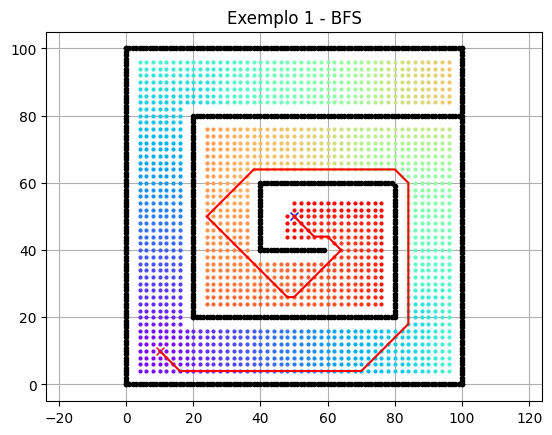

In [ ]:
#Calculando caminho e plotando
med_1_BFS = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = BFS(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_1_BFS.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_1_BFS)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 1 - BFS')

Tempo médio de execução:  0.042832984924316406
Número de nós visitados:  1699
Tamanho do Caminho:  121.21320343559638 m


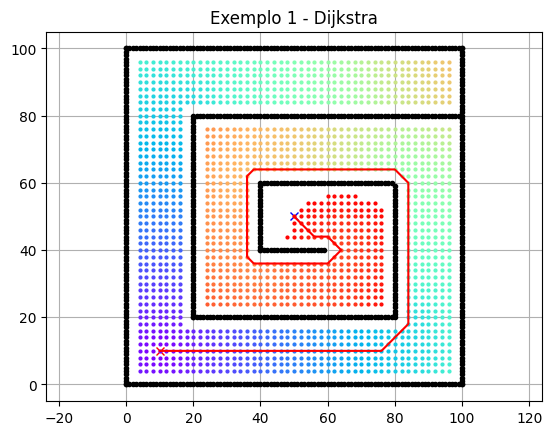

In [ ]:
#Calculando caminho e plotando
med_1_dij = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = Dijkstra(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_1_dij.append(time_fim - time_inic)

print("Tempo médio de execução: ", sum(med_1_dij)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 1 - Dijkstra')

Tempo médio de execução:  0.09685518503189088
Número de nós visitados:  1535
Tamanho do Caminho:  121.21320343559638 m


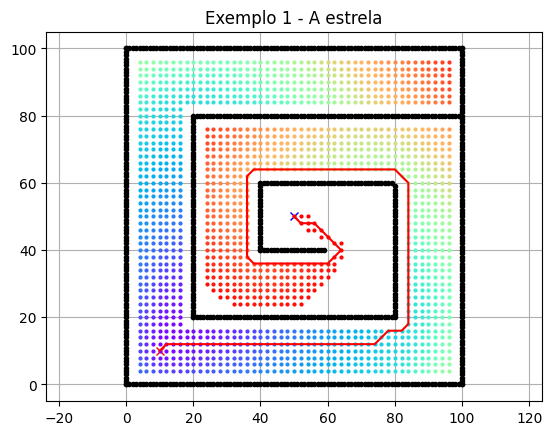

In [ ]:
#Calculando caminho e plotando
med_1_A_estrela = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = A_estrela(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_1_A_estrela.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_1_A_estrela)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 1 - A estrela')

In [ ]:
# Exemplo 2 - Pessoas em posicoes aleatorias

import random

inicio_x = 10.0
inicio_y = 10.0
fim_x = 90.0
fim_y = 90.0
passo = 2
raio_robo = 3

obstaculos_x, obstaculos_y = [], []



for i in range(50):
  while True:
    pessoa_x = random.randint(0,1000) / 10
    pessoa_y = random.randint(0,1000) /10
    d_inicio = np.sqrt( (pessoa_x-inicio_x)**2 + (pessoa_x-inicio_y)**2 )
    d_fim = np.sqrt( (pessoa_x-fim_x)**2 + (pessoa_x-fim_y)**2 )
    if ((d_inicio > raio_robo) and (d_fim > raio_robo)):
      obstaculos_x.append(pessoa_x)
      obstaculos_y.append(pessoa_y)
      break



grid=Grid(obstaculos_x,obstaculos_y,passo,raio_robo)

Neste exemplo percebemos a desvantagem do **BFS** em relação aos outros, no qual ele percorre praticamente toda a malha diferentemente do **Dijkstra** e do **A*** que possui uma informação para guia-los, porém seu tempo de execução ainda foi menor do que o **Dijkstra**.

Além disso percebe-se uma superioridade de performance do algoritmo **A*** em comparação com **Dijkstra**, tanto em relação ao número de nós visitados (o **A*** visita uma quantidade muito menor), quanto o tempo de execução médio.

Tempo médio de execução:  0.030780799388885498
Número de nós visitados:  2058
Tamanho do Caminho:  57.74011537017758 m


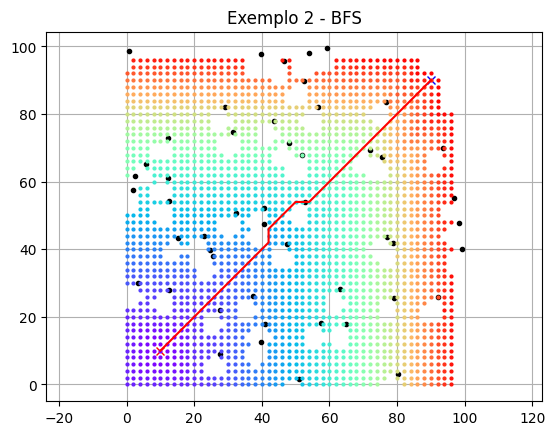

In [ ]:
#Calculando caminho e plotando
med_2_BFS = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = BFS(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_2_BFS.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_2_BFS)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 2 - BFS')

Tempo médio de execução:  0.11850257158279419
Número de nós visitados:  2641
Tamanho do Caminho:  57.74011537017758 m


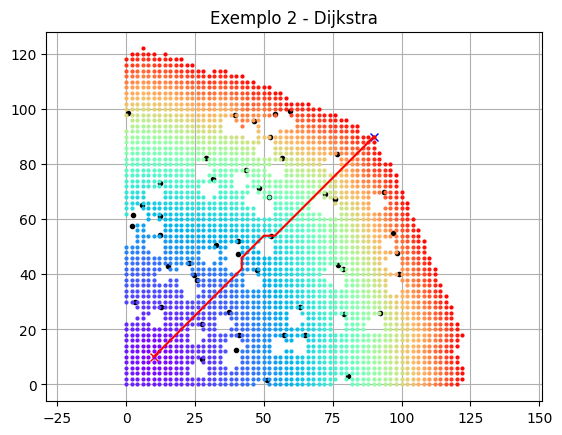

In [ ]:
med_2_dij = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = Dijkstra(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_2_dij.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_2_dij)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 2 - Dijkstra')

Tempo médio de execução:  0.021865291595458983
Número de nós visitados:  178
Tamanho do Caminho:  57.74011537017758 m


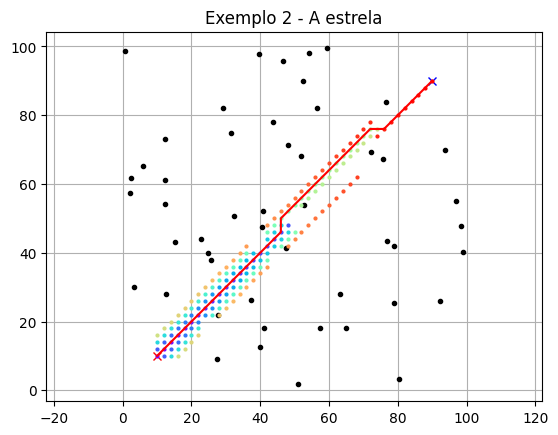

In [ ]:
#Calculando caminho e plotando
med_2_A_estrela = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = A_estrela(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_2_A_estrela.append(time_fim - time_inic)

print("Tempo médio de execução: ", sum(med_2_A_estrela)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 2 - A estrela')

In [ ]:
# Exemplo 3 - Paredes e pessoas

#Definindo posições inicial e final e gerando grid de obstáculos
inicio_x = 10.0
inicio_y = 10.0
fim_x = 50.0
fim_y = 50.0
passo = 2
raio_robo = 3

obstaculos_x, obstaculos_y = [], []

# Defina a posição dos obstáculos no grid aqui
# (Por exemplo):
for i in range(101):
    obstaculos_x.append(i)
    obstaculos_y.append(0)
    obstaculos_x.append(i)
    obstaculos_y.append(100)
    obstaculos_x.append(0)
    obstaculos_y.append(i)
    obstaculos_x.append(100)
    obstaculos_y.append(i)
for i in range(80):
    obstaculos_x.append(i + 20)
    obstaculos_y.append(80)
for i in range(60):
    obstaculos_x.append(20)
    obstaculos_y.append(20 + i)
for i in range(60):
    obstaculos_x.append(i + 20)
    obstaculos_y.append(20)
for i in range(40):
    obstaculos_x.append(80)
    obstaculos_y.append(i + 20)
for i in range(40):
    obstaculos_x.append(i + 40)
    obstaculos_y.append(60)
for i in range(20):
    obstaculos_x.append(40)
    obstaculos_y.append(40 + i)
for i in range(20):
    obstaculos_x.append(40 + i)
    obstaculos_y.append(40)

for i in range(50):
  while True:
    pessoa_x = random.randint(0,1000) / 10
    pessoa_y = random.randint(0,1000) /10
    d_inicio = np.sqrt( (pessoa_x-inicio_x)**2 + (pessoa_x-inicio_y)**2 )
    d_fim = np.sqrt( (pessoa_x-fim_x)**2 + (pessoa_x-fim_y)**2 )
    if ((d_inicio > raio_robo) and (d_fim > raio_robo)):
      obstaculos_x.append(pessoa_x)
      obstaculos_y.append(pessoa_y)
      break



grid=Grid(obstaculos_x,obstaculos_y,passo,raio_robo)

> No último exemplo, vemos , mais uma vez, o destaque do algoritmo **A*** em comparação ao **Dijkstra**, comparando novamente os nós visitados por cada um. Dessa vez, utilizando um ambiente com paredes e obstáculos, o algoritmo **A*** apresentou performance aproximada de 10% superior em comparação ao **Dijkstra**. O algoritmo **Dijkstra** apresenta tempo de execução médio menor que o **A*** nesse caso. A performance do **BFS** permanece parecida com o do exemplo 1, com tempo de execução e número de nós visitados parecido com o **Dijkstra**, porém ele possui uma pequena vantagem em relação ao tempo de execução.

Tempo médio de execução:  0.020381255149841307
Número de nós visitados:  1442
Tamanho do Caminho:  142.0243866176395 m


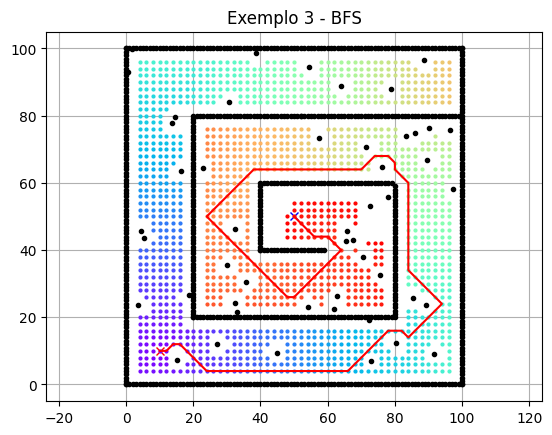

In [ ]:
#Calculando caminho e plotando
med_3_BFS = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = BFS(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_3_BFS.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_3_BFS)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, 'Exemplo 3 - BFS')

Tempo médio de execução:  0.024288768768310546
Número de nós visitados:  1441
Tamanho do Caminho:  128.7695526217004 m


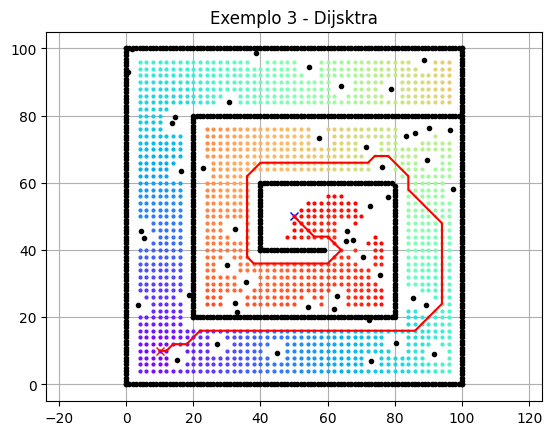

In [ ]:
med_3_dij = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = Dijkstra(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_3_dij.append(time_fim - time_inic)
print("Tempo médio de execução: ", sum(med_3_dij)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, "Exemplo 3 - Dijsktra")

Tempo médio de execução:  0.06937488794326782
Número de nós visitados:  1336
Tamanho do Caminho:  128.7695526217004 m


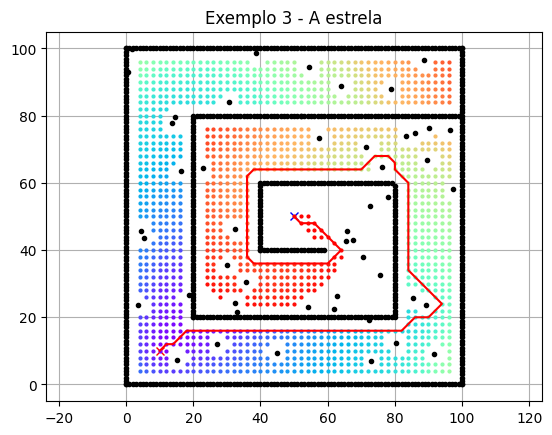

In [ ]:
#Calculando caminho e plotando
med_3_A_estrela = []
for _ in range(100):
  time_inic = time.time()
  caminho_x, caminho_y, nos_visitados = A_estrela(No(round(inicio_x / passo), round(inicio_y / passo), 0.0, -1),
                                          No(round(fim_x / passo), round(fim_y / passo), 0.0, -1),
                                            grid)
  time_fim = time.time()
  med_3_A_estrela.append(time_fim - time_inic)

print("Tempo médio de execução: ", sum(med_3_A_estrela)/100)
print("Número de nós visitados: ", len(nos_visitados))
print("Tamanho do Caminho: ", nos_visitados[(round(fim_x/ passo),round(fim_y / passo))].custo, "m")
visualizar(caminho_x, caminho_y, obstaculos_x, obstaculos_y, inicio_x, inicio_y, fim_x, fim_y, nos_visitados, passo, "Exemplo 3 - A estrela")

## 7. Conclusões finais

> Avaliando o desempenho dos três algoritmos, percebe-se que, nos três casos estudados acima, o algoritmo **A*** sempre visita menos nós. Em contrapartida, nem sempre apresenta o tempo de execução médio menor. Isso acontece por conta da complexidade de cada algoritmo, mas a tendência é que, utilizando uma boa função heurística, com o aumento do número de nós e número de caminhos possíveis, o **A*** se torne mais eficiente.

> Um bom exemplo para confirmar a tese é o **Exemplo 2**. Enquanto o algoritmo **Dijkstra** e o **BFS** iniciam percorrendo vários nós no seu entorno, o algoritmo **A*** segue um caminho quase linear em direção ao ponto final.

> Já nos outros exemplos (**Exemplo 1** e **Exemplo 3**), em que o caminho a se percorrer é "cercado" pelas paredes, os algoritmos tem pouca diferença em desempenho, visto que os caminhos tem uma demarcação que favorecem o algoritmo **Dijkstra** e o **BFS**.

> Por fim, ambos os algoritmos de busca informada atingiram o ponto final do percurso, encontrando o caminho ótimo - de menor custo em distância.




